# 4. Modelado del conjunto de datos
A lo largo de este notebook se cubre parte de la cuarta fase de la metodología CRIPS-DM, en este caso el modelado del conjunto de datos. En este notebook se emplea para el mismo un ensemble conformado por SAM + RetineNet

1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo del proyecto.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en :


3. **Preparación de los Datos (Data Preparation)** 
   - Consistente en la limpieza, preparación y extracción de características de los datos.

4. <span style="color:#66FF99;">**Modelado (Modeling)**  </span> 
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico. En este caso, el modelo a emplear se tratará de un ensemble que combina RetinaNet con Segment Anything Model.

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso.


### Arquitectura propuesta


En este caso, la arquitectura propuesta, representada inferiormente, puede dividirse en dos bloques diferenciados:

1) Detector de objetos mediante RetinaNet, obtieninedo como salida las bounding-boxes asociadas.
2) Segmentador de instancias mediante Segment Anything Model a partir de las bounding boxes anteriores.
3) Agrupador de máscaras de instancias en formato de imagen con las máscaras de la segmentación semántica correspondiente.


<img src="./../assets/figs/proposed_retinnet.png" alt="Arquitectura propuesta empleando RetinaNet" style="width: 70%; height: auto;">

### Detector de objetos

Como primer bloque de la pipeline se desarrolla el código equivalente para la realización de la detección de los objetos.

Para ello se emplea el modelo Retinanet, empleado principalmente por el uso de la funcoón de pérdida focal loss que mejora los resultados tras el entrenamiento en clases que ocupan espacios pequeños en fondos grandes, como sucede en este dataset. 

La aruitectura de este modeo se observa inferiormente:


<img src=".\..\assets\figs\The-architecture-of-the-proposed-model-R-RetinaNet.png" alt="Arquitectura propuesta empleando RetinaNet" style="width: 60%; height: auto;">

In [19]:
import importlib
import utils 

importlib.reload(utils)

from tqdm import tqdm
from torchvision.models.detection import retinanet_resnet50_fpn
import torchvision.transforms as T

from PIL import Image
import torch
import numpy as np
import os
from pycocotools.coco import COCO
import cv2
from utils import  load_yaml_file
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt
import time
import matplotlib.patches as patches
import matplotlib.patches as mpatches

from utils import plot_image_and_mask, mask_generator, mask_generator_one_hot, plot_one_hot_encoded_masks, plot_bounding_boxes, plot_differences_batch, plot_one_hot_encoded_masks_norm, one_hot_encoder_masks, plot_differences


from utils import save_np_array_web


En primera instancia se realiza la del modelo y sus pesos asociados, en este caso del conjunto de modelos entrenados de torchvision

In [20]:
model = retinanet_resnet50_fpn(pretrained=True)

c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Se imprime su estructura en detalle y se pone el modelo en modo `eval`, bloqueando así el entrenamiento

In [21]:
model.eval()  

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


Se carga un subconjunto de imágenes del conjunto de datos, para evaluar los resultados obtenidos

In [22]:
yaml = load_yaml_file()

objetives = yaml["objetive_classes"]


# Tamaño muestral usado para evaluar el rendimiento del modelo
N = yaml["size_sample"]

Se inicializa la API de coco para un tratamiento más ágil.

In [23]:

N_CLASSES = len(objetives) + 1

DIR_TRAIN_ANNOTATIONS = yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS = yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS = os.path.abspath(os.path.join(os.getcwd(), "..", DIR_TRAIN_IMGS))

coco=COCO(os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...
Done (t=43.69s)
creating index...
index created!


In [ ]:
categories = coco.loadCats(coco.getCatIds())
category_info_id = {cat['id']: cat['name'] for cat in categories}
category_info_name = { cat['name']:cat['id'] for cat in categories}

id_objetives = [category_info_name[name] for name in objetives]
category_info_objetive = {i:category_info_id[i] for i in id_objetives}
category_info_objetive[0] = "background"
categories_names_by_index = { i: category_info_objetive[id_cat] for i , id_cat in enumerate(sorted(category_info_objetive.keys()))}


dict_class_index = {key:i for i , key in enumerate(sorted(category_info_objetive.keys()))}
mapper_indexModel_index_result = {value:i for i, value in enumerate(sorted(category_info_objetive.keys()))}



Asimismo, las variables globales que afectan a ambos modelos. En este caso , la primera se trata de un threshold que omitirá detecciones de objetos con confianza poco significativas. La segunda, del threshold que omitirá máscaras y partes de la misma con una probabilidad asociada menor a la dada.

In [25]:
CONS_TRHESHOLD = 0.3
CONS_THRESHOLD_SEGMENTATION = 0.5

In [26]:

img_ids = set(coco.getImgIds(catIds=id_objetives[0]))

for cat in id_objetives[1:]:
    img_ids |= set(coco.getImgIds(catIds=cat))

img_ids = list(img_ids)


print(f"Las imagenes con alguna instancia de las clases target son {len(img_ids)}")

Las imagenes con alguna instancia de las clases target son 79542


In [442]:
img, mascara =  mask_generator(coco,img_ids[0], id_objetives  ,DIR_TRAIN_IMGS,  threshold = 200)


Se comprueba de forma gráfica que la carga de los datos ha sido correcta

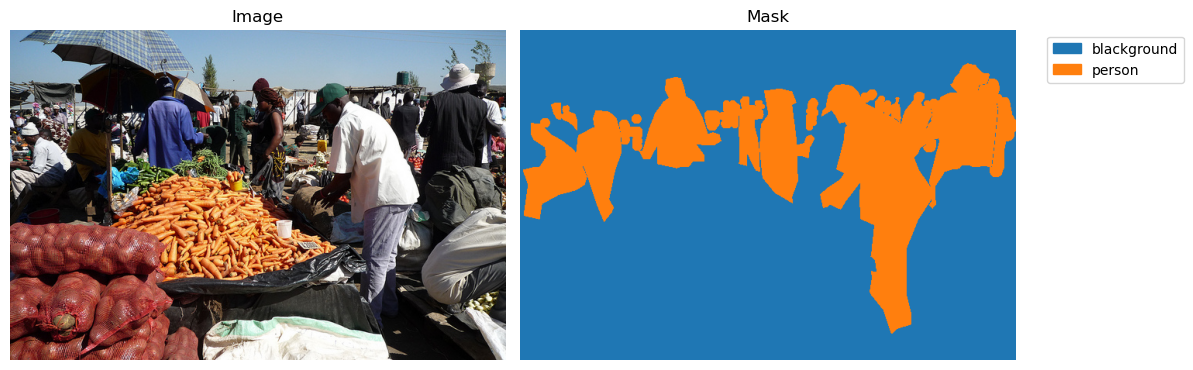

In [ ]:
plot_image_and_mask(img, mascara, category_info_objetive)

Para el uso del modelo, se convierte el `np.array` en `torch.Tensor` para poder ingestar en el modelo, dado que esta implementado en torch en lugar de Tensorflow.

In [445]:
img_ids = coco.getImgIds()
img_info = coco.loadImgs(img_ids[0])[0]
img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"

image = Image.open(img_path).convert("RGB")

transform = T.Compose([
    T.ToTensor()
])
img_tensor = transform(image).unsqueeze(0)

Llamamos a la ejecucuón para esta primera instancia y comprobar el funcionamiento de la detección

In [446]:
with torch.no_grad():
    outputs = model(img_tensor)

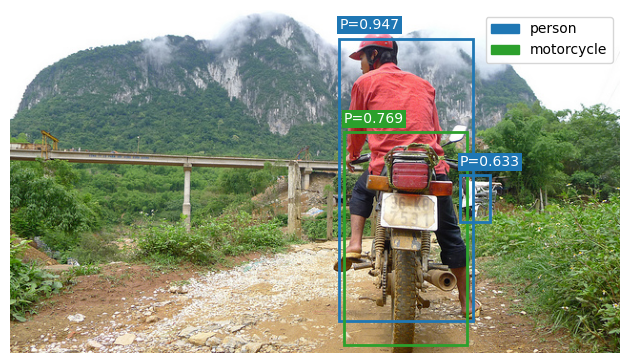

In [ ]:
plot_bounding_boxes(image=image,result= outputs[0],category_info_objetive=category_info_objetive, threshold=0.5)

Una vez testeada, se automatiza la detección de objetos en un subconjunto de las imágenes, que supondrán la salida del primer bloque del modelo.

In [ ]:

id_images = []
images = []
results_detection = []

for img_id in tqdm(img_ids[:N], desc="Generando las bounding boxes", total= N):

    img_info = coco.loadImgs(img_id)[0]
    img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"
    image = Image.open(img_path).convert("RGB")

    transform = T.Compose([
        T.ToTensor()
    ])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img_tensor)
        
    results_detection.append(outputs)
    id_images.append(img_id)
    images.append(image)

Generando las bounding boxes: 100%|██████████| 100/100 [11:51<00:00,  7.12s/it]


Se representa un subconjunto como ejemplo, haciendo uso de las funciones de `utils.py`

C:\Users\ruben\AppData\Local\Temp\ipykernel_60472\2949144618.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = {cls: plt.cm.get_cmap('tab10')(i) for i, cls in enumerate(id_objetives)}


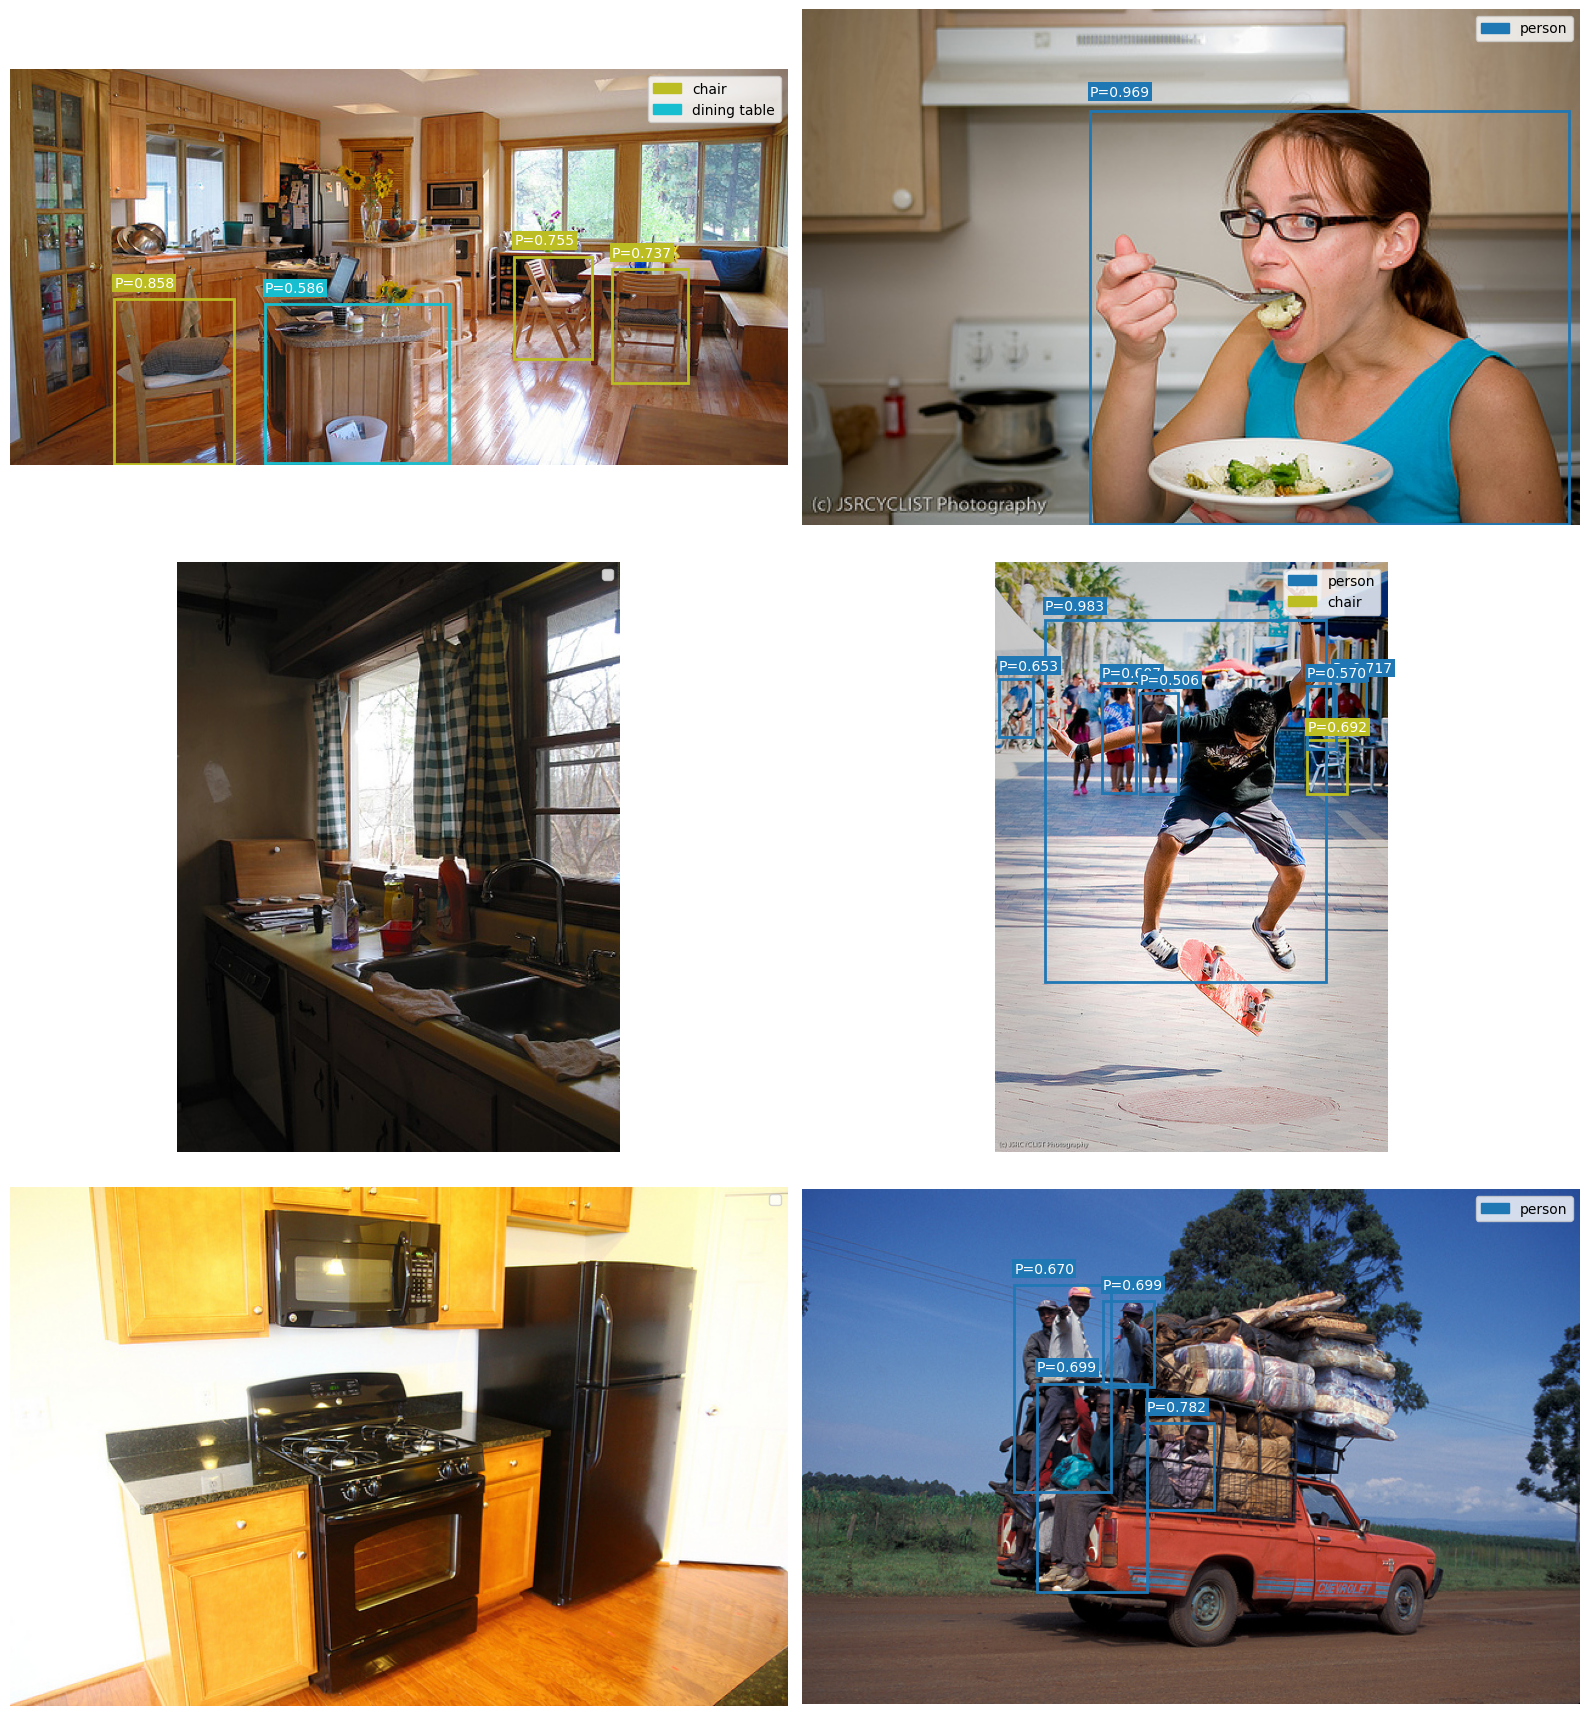

In [ ]:
results_processed  = [result_detection[0] for result_detection in results_detection]
plot_bounding_boxes(images[15:21], results_processed[15:21], category_info_objetive )

### Generador de máscaras mediante SAM

A continuación se desarrolla el segundo bloque que conforma el modelo, en este caso el bloque encargado de generar las máscaras de segmentación a partir de los bounding boxes obtenidos en el bloque anterior. como modelo empleado se ha saleccionado SAM, de Meta, modelo fundacional que permite usar como input un bounding box para encaminar las predicciones de máscaras. La arquitectura a grandes rasgos de los componentes del mismo es tal que:

<img src=".\..\assets\figs\segment-anything-model.png" alt="Arquitectura del modelo SAM" style="width: 70%; height: auto;">

In [39]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

En este caso nos decantamos por el modelo de mayor número de parámetros (modelo huge, de 4.89 billones de parámetros) para la obtención de los resultados de la mejor calidad posible.

In [40]:

sam_checkpoint = r"C:\Users\ruben\Desktop\code_tfm\models\SAM\sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device= "cpu" )

sam_model = SamPredictor(sam)


Probamos la segmentación de las n primeras imágenes para determinar si los resultados son correctos

In [ ]:
final_masks = []
masks_scores = []
masks_logits = []
ids_image = []

segmentation_results = []
for i, (img_id, results_detection) in enumerate(tqdm(zip(id_images[:N], results_processed), total= N)):

    masks_image = []
    scores_image = []
    logits_image = []

    img_info =coco.loadImgs(img_id)[0]
    img_path =f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"
    image =cv2.imread(img_path)

    #print(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sam_model.set_image(image)

    for box, score, label in zip(results_detection['boxes'], results_detection['scores'], results_detection['labels']):
        if(score > CONS_TRHESHOLD and label.item() in category_info_objetive.keys()):
            masks, scores, logits = sam_model.predict(
                point_coords=None,
                point_labels=None,
                box= np.array(box.tolist())[None,:] ,
                multimask_output=False
            )

            masks_image.append(masks)
            scores_image.append(scores)
            logits_image.append(logits)

    final_masks.append(masks_image)
    masks_scores.append(scores_image)
    masks_logits.append(logits_image)
    ids_image.append(img_id)




100%|██████████| 5/5 [09:32<00:00, 114.43s/it]


Se define una función que preprocesa las probabilidades asociadas a las máscaras y la máscada bidimensional, para obtener la matriz de `logits` asociada

In [483]:
def get_one_hot_scores(current_scores, mask,categories_names_by_index ):
    mask = mask[0]
    one_hot_scores = np.zeros((len(categories_names_by_index), mask.shape[0], mask.shape[1]))

    for clase in sorted(categories_names_by_index.keys()):
        # print("mask shapes", mask.shape)
        # print("class", clase)
        # print("shapes ", one_hot_scores.shape)
        # print("scores shape ", current_scores.shape)
        one_hot_scores[clase, :, :] = np.where(mask == clase,current_scores[0, :, :]  , 0)

    one_hot_scores[0, :, :] = 1 - one_hot_scores[1:, :, :].sum(axis=0)

    #print("output has shape", one_hot_scores.shape)

    return one_hot_scores



In [512]:
dict_class_index = {key:i for i , key in enumerate(sorted(category_info_objetive.keys()))}


Se realiza el procesamiento de las N priemras instancias

In [ ]:

final_masks = []
masks_scores = []
masks_logits = []
ids_image = []
one_hot_scores = []
mask_index = []


for i, (img_id, results_detection) in enumerate(tqdm(zip(id_images[:N], results_processed), total=len(id_images[:5]))):

    masks_image = []
    mask_target = []
    scores_image = []
    logits_image = []
    labels_image = []
    mask_probs_image = []

    img_info = coco.loadImgs(img_id)[0]
    img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sam_model.set_image(image)

    final_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    current_scores = np.zeros(image.shape[:2], dtype=np.uint8)

    for box, score, label in zip(results_detection['boxes'], results_detection['scores'], results_detection['labels']):
        if(score > CONS_TRHESHOLD and label.item() in category_info_objetive.keys()):
            masks, scores, logits = sam_model.predict(
                point_coords=None,
                point_labels=None,
                box= np.array(box.tolist())[None, :] ,
                multimask_output=False
            )
            
            
            # print("image has shape ",image.shape )
            # print("mask have shape ",masks.shape )
            # print("logits has shape ",logits.shape )
            
            # print("\n")
            
            masks_image.append(masks)
            scores_image.append(scores)
            logits_image.append(logits[0])
            labels_image.append(label.item())

    # print("scores are ", scores_image, "for classes ", labels_image)


    for mask, mask_score, label in zip(masks_image, scores_image, labels_image):
        if np.any(mask):
            # print("mask has avlue and label is ", label)
            mask_values = np.where(mask, mask_score, 0)
            final_mask = np.where(mask_values > current_scores , label, final_mask)

            # print("current final value is ", np.unique(final_mask))
            current_scores = np.maximum(mask_values, current_scores)

    # print("\n\n")




    final_masks.append(final_mask)
    masks_scores.append(current_scores)

    lookup = np.vectorize(lambda k: dict_class_index[k])
    mask_by_index = lookup(final_mask)
    mask_index.append(mask_by_index) 
    one_hot_scores.append(get_one_hot_scores(current_scores,mask_by_index,categories_names_by_index))

    #masks_logits.append(stacked_logits)
    ids_image.append(img_id)




  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [59:41<00:00, 716.30s/it]   


Se representa gráficamente el resultado de la primera de las instancias, y se compara el ground truth

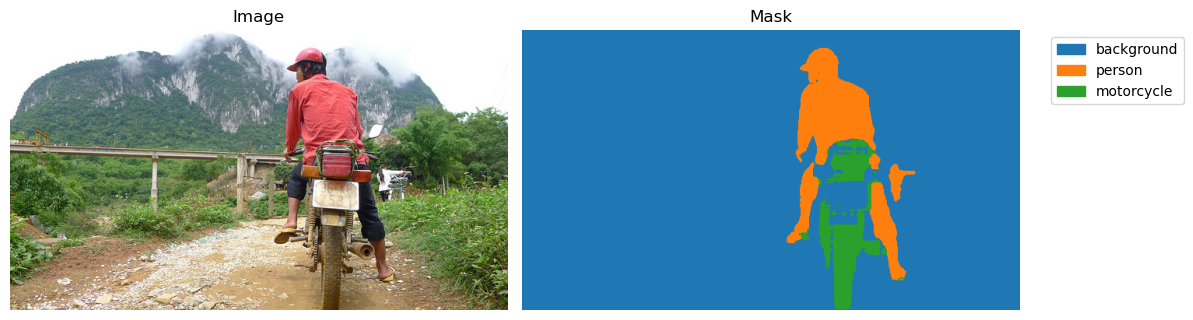

In [460]:

img_info = coco.loadImgs(ids_image[0])[0]
img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
category_info_objetive[0] = "background"
plot_image_and_mask(image, final_masks[0][0],  category_info_objetive )


In [ ]:

# Generación del ground truth para la primera de las imágenes

img_info = coco.loadImgs(ids_image[0])[0]
height, width = img_info['height'], img_info['width']

ann_ids = coco.getAnnIds(imgIds=ids_image[0])
anns = coco.loadAnns(ann_ids)

mask = np.zeros((height, width), dtype=np.uint8)

for ann in anns:
    category_id = ann['category_id']

    if(category_id in category_info_objetive.keys()):
    
        binary_mask = coco.annToMask(ann)
        mask[binary_mask == 1] = category_id



Se protea frente al glound truth para observar las diferencias, y se tiene que los resultados son inclusive mejores para la primera imagen que las propias segmentaciones aportadas en el dataset, al dar lugar a formas más precisas que se adecuan a las de la vida real. 

C:\Users\ruben\AppData\Local\Temp\ipykernel_60472\4121677733.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_id_to_name))  # or any other colormap


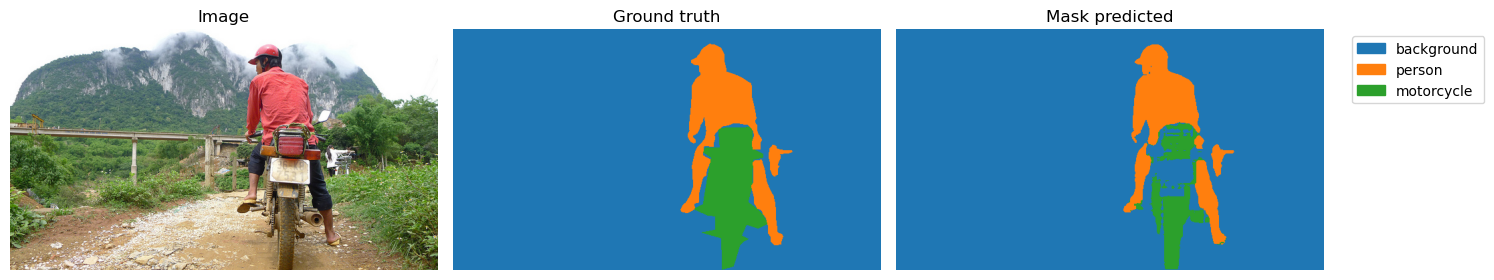

In [ ]:

plot_differences(image, mask, final_masks[0][0],category_info_objetive)

Se comprueban los resultados en n imágenes

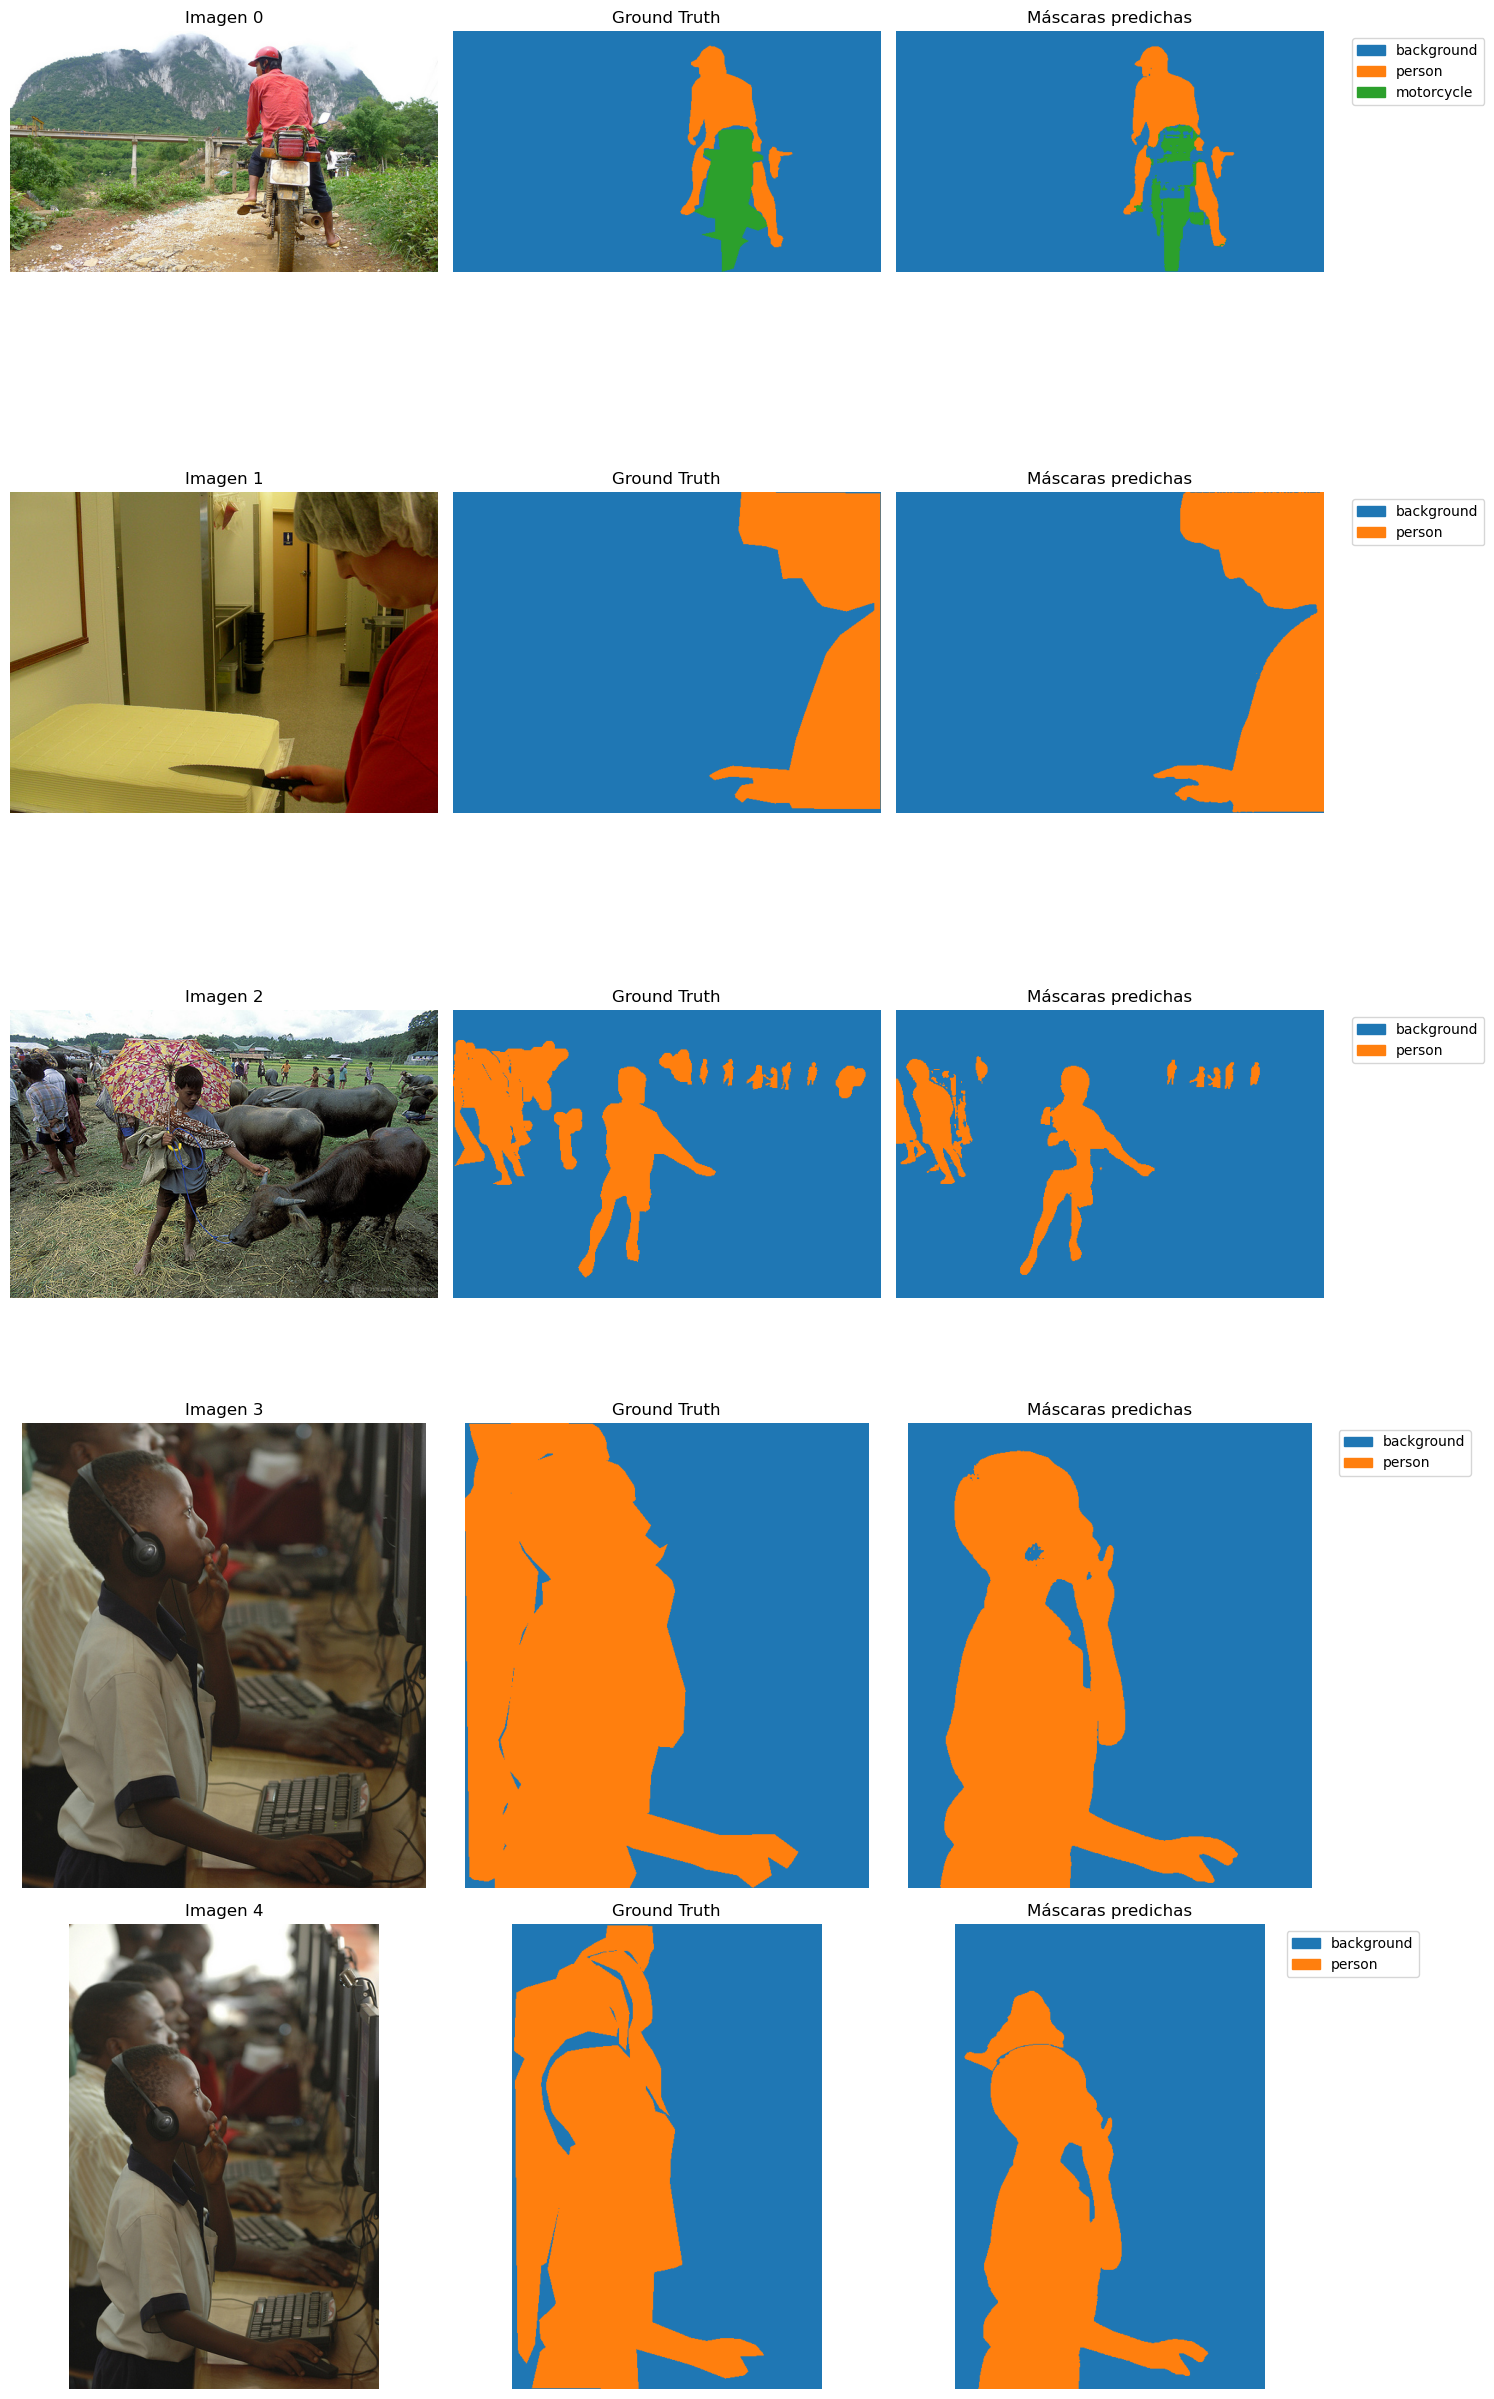

In [ ]:

# En primer lugar se generan las máscaras de la predicción de las máscaras

plot_image = []
plot_mask_gt = []
plot_mask_result = []
plot_mask_probs = []

for i, img_id in enumerate(ids_image):
    img_info = coco.loadImgs(img_id)[0]
    height, width = img_info['height'], img_info['width']

    img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((height, width), dtype=np.uint8)

    for ann in anns:
        category_id = ann['category_id']

        if(category_id in category_info_objetive.keys()):
        
            binary_mask = coco.annToMask(ann)
            # if binary_mask.shape != mask.shape:
            #     binary_mask = cv2.resize(binary_mask, (width, height), interpolation=cv2.INTER_NEAREST)
            mask[binary_mask == 1] = category_id

    plot_image.append(image)
    plot_mask_gt.append(mask)
    plot_mask_result.append(final_masks[i][0])
    



# Se representa gráficamente mediante la funcion de utils
plot_differences_batch(plot_image, plot_mask_gt, plot_mask_result, category_info_objetive)
    

### Obtención de las métricas de rendimiento

A partir de las segmentaciones, se obtienen una serie de métricas asociadas a la comparativa entre resultados y ground truth. Las métricas empleadas serán 3:

1) Mean pixel accuracy
2) Intersection over Union
3) Mean Average precission

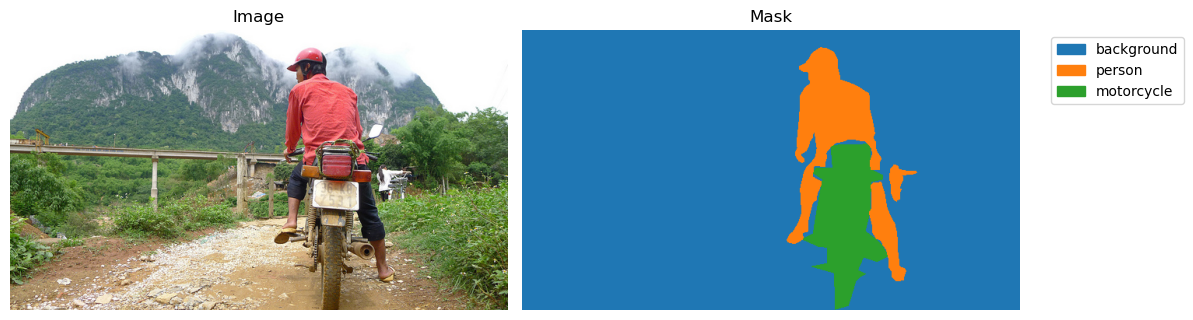

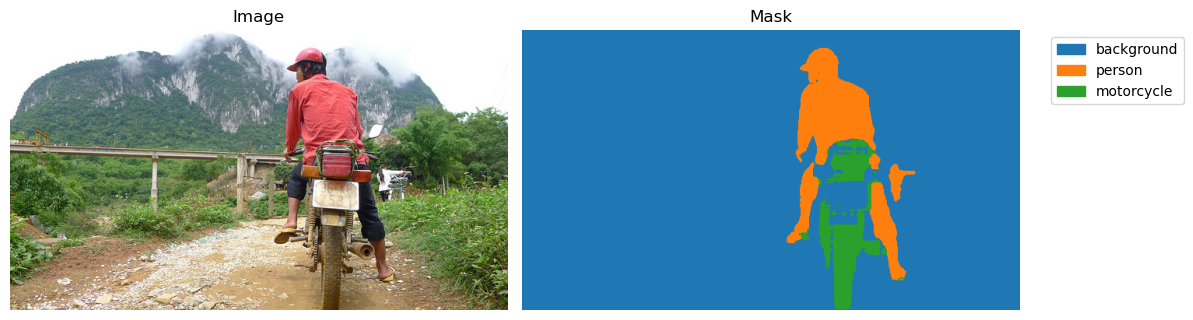

In [ ]:

# Para su obtención es necesario aplicar one hot encodding a los resultados para que estos sean compatibles con las funciones hosteadas en utils


categories_names_by_index = { i: category_info_objetive[id_cat] for i , id_cat in enumerate(sorted(category_info_objetive.keys()))}


mask_one_hot_gt = one_hot_encoder_masks(mask,  category_info_objetive)
plot_one_hot_encoded_masks_norm(image, mask_one_hot_gt, categories_names_by_index)

mask_one_hot_pred = one_hot_encoder_masks(final_masks[0][0],  category_info_objetive)
plot_one_hot_encoded_masks_norm(image, mask_one_hot_pred, categories_names_by_index)




In [ ]:

def compute_iou(pred_mask, true_mask) -> float:


    ious = []
    num_classes = pred_mask.shape[0]

    for c in range(num_classes):
        pred = pred_mask[c]
        truth = true_mask[c]

        if  truth.any():

            intersection = np.logical_and(pred, truth).sum()
            union = np.logical_or(pred, truth).sum()

            iou = intersection / union if union != 0 else 0.0
            ious.append(iou)

            #print("For class ", c, " has value ", iou)



    return np.mean(ious)



result = compute_iou(mask_one_hot_pred, mask_one_hot_gt)



In [ ]:

def mean_pixel_accuracy(pred_mask, true_mask) -> float:


    class_accuracies = []

    for c in range(pred_mask.shape[0]):
        pred = pred_mask[c]
        truth = true_mask[c]

        total_true = truth.sum()
        if total_true != 0:

            correct = np.logical_and(pred, truth).sum()
            acc = correct / total_true
            class_accuracies.append(acc)
            
            #print("For class ", c, " has value ", acc)

    return np.mean(class_accuracies)

result = mean_pixel_accuracy(mask_one_hot_pred, mask_one_hot_gt)



In [ ]:


def mean_average_precision(prob_mask, true_mask) -> float:

    C, H, W = true_mask.shape
    aps = []

    for c in range(C):
        y_true = true_mask[c].ravel().astype(int)
        y_score = prob_mask[c].ravel()

        if y_true.sum() != 0:
            ap = average_precision_score(y_true, y_score)
            aps.append(ap)

            print("for ", c, " has value ",ap)


    return np.mean(aps)


mean_average_precision(one_hot_scores[0],mask_one_hot_gt )

for  0  has value  0.9706966302503756
for  1  has value  0.9281707990549951
for  3  has value  0.05269097222222222


0.6505194671758643

### Pipeline final


Se construye el pipeline final que dado un conjunto de imágenes realiza la inferencia y calcula todas las métricas:

In [36]:
def get_data_id_image(id_image, coco):

    img_info = coco.loadImgs(id_image)[0]
    height, width = img_info['height'], img_info['width']
    img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(imgIds=id_image)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((height, width), dtype=np.uint8)

    for ann in anns:
        category_id = ann['category_id']

        if(category_id in category_info_objetive.keys()):
            binary_mask = coco.annToMask(ann)
            mask[binary_mask == 1] = category_id

    return image, mask




In [52]:
def process_inference_retina_sam(image, retina_model, sam_model, mapper_indexModel_index_result, category_info_objetive):

    # RETINANET INFERENCE

    transform = T.Compose([
        T.ToTensor()
    ])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        inference = retina_model(img_tensor)
        inference = inference[0]


    # SAM INFERENCE

    sam_model.set_image(image)
    final_mask = np.zeros(image.shape[:2], dtype=np.int8)
    current_scores = np.zeros(image.shape[:2], dtype=np.float32)

    masks_image = []
    scores_image = []
    labels_image = []
    #category_info_objetive = {v: k for k, v in categories_index_by_name.items()}
    print(inference)
    print(f"{inference['boxes']}=")
    
    for box, score, label in zip(inference['boxes'], inference['scores'], inference['labels']):
        if(score > CONS_TRHESHOLD and label.item() in category_info_objetive.keys()):
            label = mapper_indexModel_index_result[label.item()]
            masks, scores, _ = sam_model.predict(
                point_coords=None,
                point_labels=None,
                box= np.array(box.tolist())[None,:],
                multimask_output=False
            )
            if np.any(masks):
                masks_image.append(masks)
                scores_image.append(scores)
                labels_image.append(label)

                mask_values = np.where(masks, scores, 0)
                final_mask = np.where(mask_values > current_scores , label, final_mask)
                current_scores = np.maximum(mask_values, current_scores)


    return final_mask[0], current_scores[0]


In [53]:
image, mask = get_data_id_image(img_ids[0], coco)

retina_model = retinanet_resnet50_fpn(pretrained=True)
retina_model.eval()  


final_mask, current_scores = process_inference_retina_sam(image, retina_model, sam_model, mapper_indexModel_index_result, category_info_objetive)


c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'boxes': tensor([[367.2416,  75.4196, 534.7239, 379.7655],
        [161.7360,  59.5591, 259.4107, 182.3475],
        [  1.1119, 123.1306,  76.7846, 239.0993],
        ...,
        [526.3265, 142.4706, 639.8796, 377.3008],
        [144.9366, 156.8890, 338.3585, 249.4855],
        [307.5289,  31.2822, 593.6708, 404.0766]]), 'scores': tensor([0.8786, 0.8623, 0.7747, 0.7294, 0.7255, 0.7201, 0.6892, 0.6872, 0.6580,
        0.6566, 0.6258, 0.6193, 0.5828, 0.5755, 0.5211, 0.4971, 0.4574, 0.4457,
        0.4399, 0.4216, 0.4104, 0.4090, 0.3970, 0.3968, 0.3766, 0.3748, 0.3653,
        0.3559, 0.3532, 0.3521, 0.3364, 0.3311, 0.3304, 0.3181, 0.3088, 0.3036,
        0.3024, 0.3013, 0.2983, 0.2931, 0.2862, 0.2837, 0.2723, 0.2717, 0.2680,
        0.2674, 0.2656, 0.2652, 0.2631, 0.2622, 0.2599, 0.2588, 0.2564, 0.2560,
        0.2546, 0.2526, 0.2520, 0.2477, 0.2477, 0.2473, 0.2453, 0.2404, 0.2394,
        0.2385, 0.2361, 0.2360, 0.2358, 0.2357, 0.2334, 0.2333, 0.2330, 0.2321,
        0.2318, 0.2299, 0

In [54]:
def get_one_hot_scores(current_scores, mask,categories_names_by_index ):
    mask = mask[0]
    one_hot_scores = np.zeros((len(categories_names_by_index), mask.shape[0], mask.shape[1]))

    for clase in sorted(categories_names_by_index.keys()):
        # print("mask shapes", mask.shape)
        # print("class", clase)
        # print("shapes ", one_hot_scores.shape)
        # print("scores shape ", current_scores.shape)
        one_hot_scores[clase, :, :] = np.where(mask == clase,current_scores[0, :, :]  , 0)

    one_hot_scores[0, :, :] = 1 - one_hot_scores[1:, :, :].sum(axis=0)

    #print("output has shape", one_hot_scores.shape)

    return one_hot_scores

In [55]:
category_info_objetive

{1: 'person',
 3: 'car',
 4: 'motorcycle',
 6: 'bus',
 10: 'traffic light',
 27: 'backpack',
 31: 'handbag',
 77: 'cell phone',
 62: 'chair',
 67: 'dining table',
 0: 'background'}

KeyError: 7

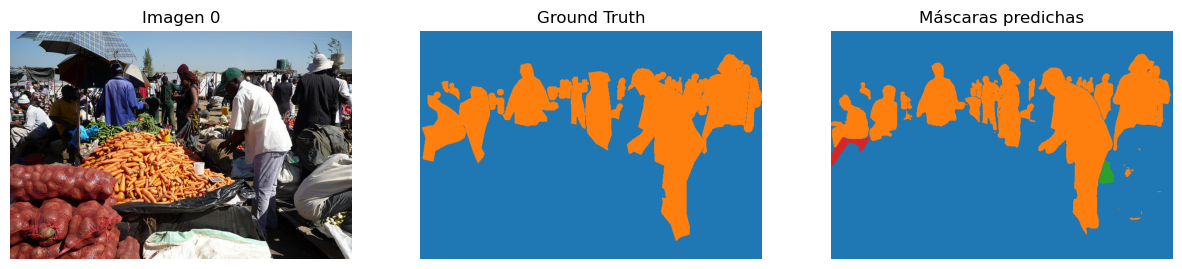

In [57]:
# final_masks = get_one_hot_scores(final_mask, current_scores,categories_names_by_index )
plot_differences_batch([image], [mask], [final_mask], category_info_objetive)


In [ ]:
def get_value_metrics(prob_mask, ground_truth) -> tuple[float, float, float ]:

    mask_one_hot_gt = one_hot_encoder_masks(mask,  category_info_objetive)
    mask_one_hot_pred = one_hot_encoder_masks(final_masks[0][0],  category_info_objetive)

    # result = mean_pixel_accuracy(mask_one_hot_pred, mask_one_hot_gt)
    mean_pixel_acc = mean_pixel_accuracy(prob_mask, ground_truth)

    # result = compute_iou(mask_one_hot_pred, mask_one_hot_gt)

    iou = compute_iou(prob_mask, ground_truth)

    # mean_average_precision(one_hot_scores[0],mask_one_hot_gt )
    mean_av_pre = mean_average_precision(prob_mask, ground_truth)
    
    return mean_pixel_acc, iou, mean_av_pre



In [ ]:
plot_image = []
plot_mask_gt = []
plot_mask_result = []
plot_mask_probs = []

for i, img_id in tqdm(enumerate(ids_image[:N])):
    img_info = coco.loadImgs(img_id)[0]
    height, width = img_info['height'], img_info['width']

    img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((height, width), dtype=np.uint8)

    for ann in anns:
        category_id = ann['category_id']

        if(category_id in category_info_objetive.keys()):
        
            binary_mask = coco.annToMask(ann)
            # if binary_mask.shape != mask.shape:
            #     binary_mask = cv2.resize(binary_mask, (width, height), interpolation=cv2.INTER_NEAREST)
            mask[binary_mask == 1] = category_id

    plot_image.append(image)
    plot_mask_gt.append(mask)
    plot_mask_result.append(final_masks[i][0])